In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

from CCfun  import load_references_from_h5
from CCfun  import load_metadata_from_h5
from CCfun  import select_df
from CCfun  import compute_baseline
from CCfun  import datetime_from_meta

from CCfit  import fit
from CCfit  import gauss
from CCfit  import doublegauss
from CCfit  import gauss_seed
from CCfit  import doublegauss_seed

from CCplot import plot1d

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"] = 15

In [3]:
filenames_pre  = glob.glob("/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre*")
filenames_post = glob.glob("/Users/Gonzalo/github/CCdata/Seattle/Seattle_post*")

In [4]:
references_pre  = list(map(load_references_from_h5, filenames_pre ))
references_post = list(map(load_references_from_h5, filenames_post))
metadatas_pre   = list(map(load_metadata_from_h5  , filenames_pre ))
metadatas_post  = list(map(load_metadata_from_h5  , filenames_post))
datetimes_pre   = list(map(datetime_from_meta     , metadatas_pre ))
datetimes_post  = list(map(datetime_from_meta     , metadatas_post))

In [5]:
references_pre[0].head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        2        2          0        1000    264  0.099976   
1       False        2        2          0        1000    264  0.099976   
2       False        2        2          0        1000    264  0.099976   
3       False        2        2          0        1000    264  0.099976   
4       False        2        2          0        1000    264  0.099976   

   ex_wl     power   em_wl  counts  
0  800.0  0.000004  484.75    3053  
1  800.0  0.000004  485.25    3047  
2  800.0  0.000004  485.75    3047  
3  800.0  0.000004  486.25    3071  
4  800.0  0.000004  486.75    3063

/Applications/anaconda3/envs/CC/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


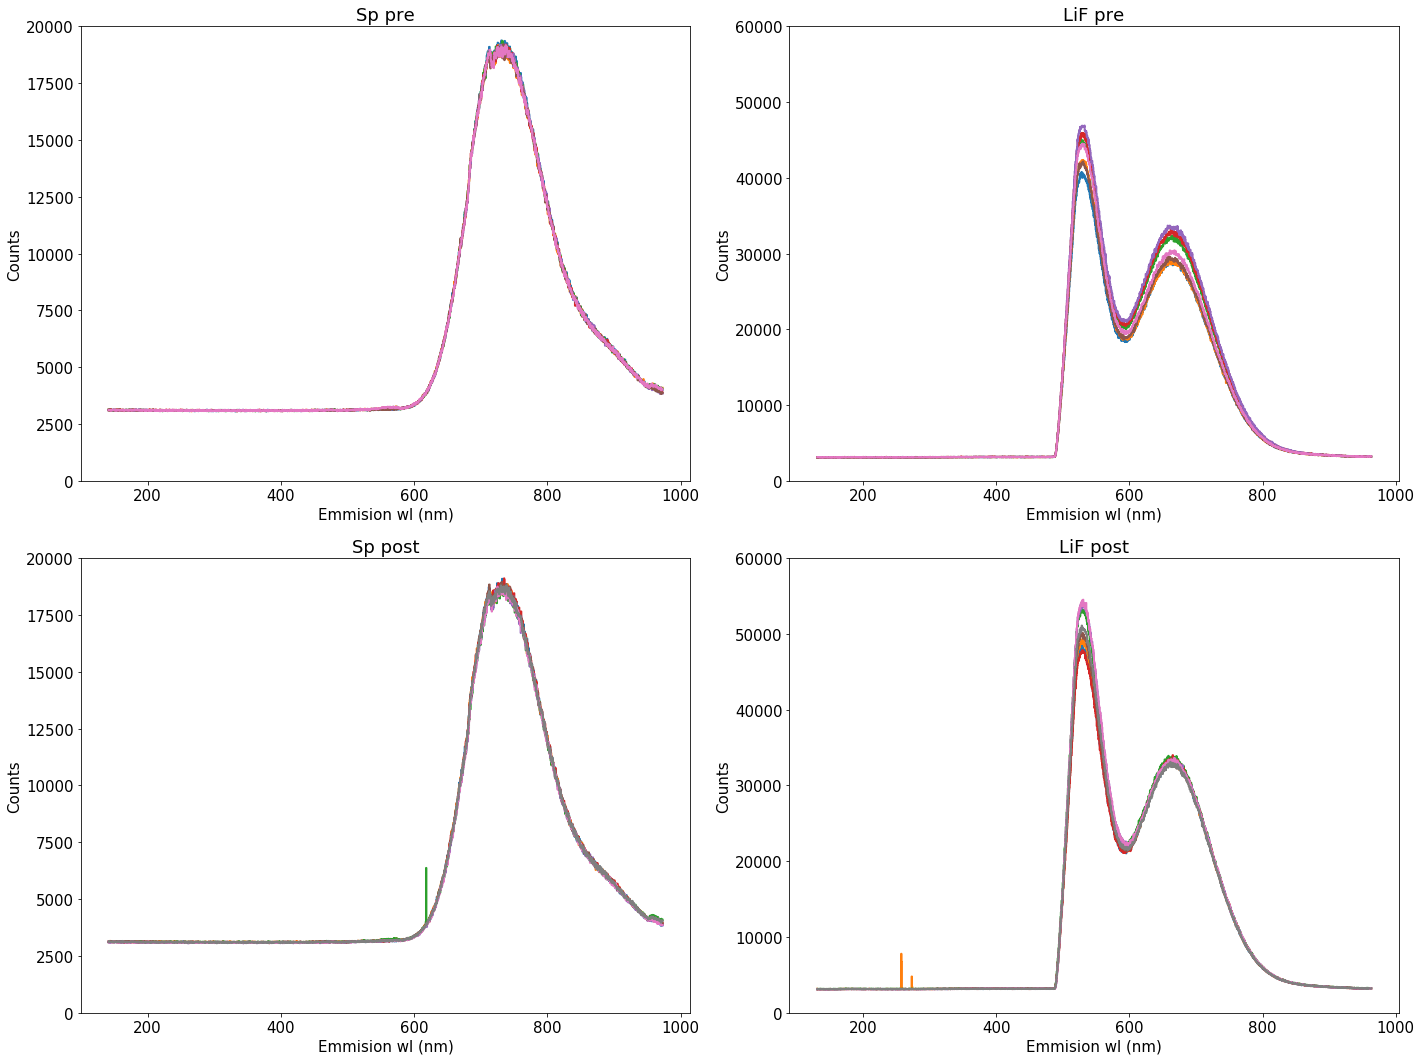

In [6]:
exposures = {0: 10, 3: 1}
crystals  = {0: "Sp", 3:"LiF"}
ylimits   = {0: 20e3, 3: 60e3}

plt.figure(figsize=(20, 15))
for reference in references_pre:    
    for k, (crystal, exposure) in enumerate(exposures.items(), start=1):
        selections = dict(exposure=exposure, crystal=crystal, grating=2, exp_index=0)
        data = select_df(reference, selections)
        assert len(data) == 1600, len(data)

        plt.subplot(2, 2, k)
        plot1d(data.em_wl .values, data.counts.values, lw=2)
        plt.ylim(0, ylimits[crystal])
        plt.title(f"{crystals[crystal]} pre")

for reference in references_post:    
    for k, (crystal, exposure) in enumerate(exposures.items(), start=3):
        selections = dict(exposure=exposure, crystal=crystal, grating=2, exp_index=0)
        data = select_df(reference, selections)
        assert len(data) == 1600, len(data)

        plt.subplot(2, 2, k)
        plot1d(data.em_wl .values, data.counts.values, lw=2)
        plt.ylim(0, ylimits[crystal])
        plt.title(f"{crystals[crystal]} post")

    plt.tight_layout()

In [7]:
def fit_Sp(df):
    selections = dict(exposure=10, crystal=0, grating=2, exp_index=0)
    df         = select_df(df, selections)
    em_wl      = df.em_wl .values.astype(np.float32)
    counts     = df.counts.values.astype(np.float32)
    counts     = counts - compute_baseline(counts)
    wlrange    = 500, 1000
    model      = doublegauss
    seed       = doublegauss_seed(em_wl, counts, *wlrange)
    f          = fit(model, em_wl, counts, seed, fit_range=wlrange)
    return f

def fit_LiF(df):
    selections = dict(exposure=1, crystal=3, grating=2, exp_index=0)
    df         = select_df(df, selections)
    em_wl      = df.em_wl .values.astype(np.float32)
    counts     = df.counts.values.astype(np.float32)
    counts     = counts - compute_baseline(counts)
    wlrange    = 500, 1000
    model      = doublegauss
    seed       = doublegauss_seed(em_wl, counts, *wlrange)
    f          = fit(model, em_wl, counts, seed, fit_range=wlrange)
    return f

def areas(f):
    return sorted((f.values[1], f.values[4]))

In [8]:
Sp_smol , Sp_big  = zip(*map(areas, map(fit_Sp , references_pre + references_post)))
LiF_smol, LiF_big = zip(*map(areas, map(fit_LiF, references_pre + references_post)))

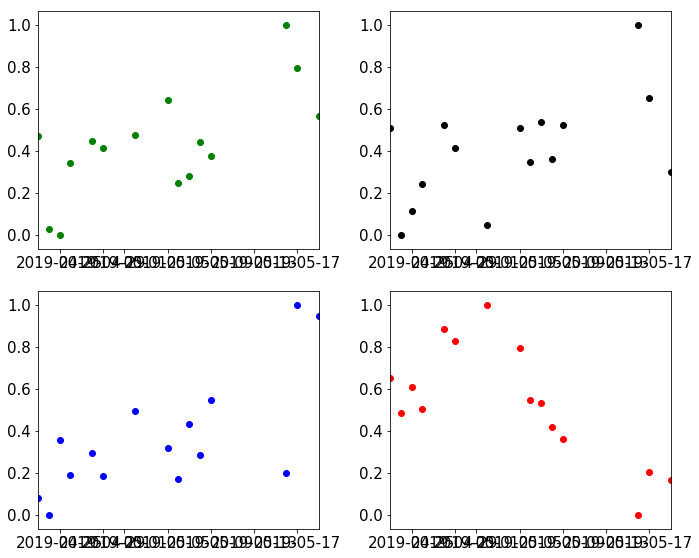

In [16]:
datetimes = datetimes_pre + datetimes_post

def norm(x, y=None):
    x  = np.array(x)
    xn = (x - x.min()) / (x.max() - x.min())
    if y is None:
        return x
    yn = y / (x.max() - x.min())
    return x, y

plt.subplot(2, 2, 1)
plt.scatter(datetimes, norm(Sp_smol), c="g", label="Sp small")
plt.xlim(min(datetimes), max(datetimes))

plt.subplot(2, 2, 2)
plt.scatter(datetimes, norm(Sp_big), c="k", label="Sp big")
plt.xlim(min(datetimes), max(datetimes))

plt.subplot(2, 2, 3)
plt.scatter(datetimes, norm(LiF_smol), c="b", label="LiF small")
plt.xlim(min(datetimes), max(datetimes))

plt.subplot(2, 2, 4)
plt.scatter(datetimes, norm(LiF_big), c="r", label="LiF big")
plt.xlim(min(datetimes), max(datetimes))
#plt.legend()
#plt.xlim(min(datetimes), max(datetimes))
plt.tight_layout()

In [20]:
datetimes = datetimes_pre + datetimes_post

def norm(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min())

plt.scatter(datetimes, norm(Sp_smol ), c="g", label="Sp small")
plt.scatter(datetimes, norm(Sp_big  ), c="k", label="Sp big")
plt.scatter(datetimes, norm(LiF_smol), c="b", label="LiF small")
plt.scatter(datetimes, norm(LiF_big ), c="r", label="LiF big")
plt.xlim(min(datetimes), max(datetimes))
plt.legend()
plt.tight_layout()